In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic-comp/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic-comp/test.csv')

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Pre-processing

In [4]:
train_df.drop(columns=['Name'], inplace=True)
test_df.drop(columns=['Name'], inplace=True)

In [5]:
train_df[['PassengerGroup', 'PassengerNumber']] = train_df['PassengerId'].str.split('_', expand=True)
test_df[['PassengerGroup', 'PassengerNumber']] = test_df['PassengerId'].str.split('_', expand=True)

In [6]:
train_df.drop(columns=['PassengerId'], inplace=True)

PassengerId = test_df['PassengerId']
test_df.drop(columns=['PassengerId'], inplace=True)

In [7]:
train_df[['Deck', 'CabinNum', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
train_df.drop(columns=['Cabin'], inplace=True)

test_df[['Deck', 'CabinNum', 'Side']] = test_df['Cabin'].str.split('/', expand=True)
test_df.drop(columns=['Cabin'], inplace=True)

### Handling missing values

### Cabin numbers

In [8]:
train_df['CabinNum'] = pd.to_numeric(train_df['CabinNum'], errors='coerce')
test_df['CabinNum'] = pd.to_numeric(test_df['CabinNum'], errors='coerce')

train_df.fillna({'Deck': 'Unknown', 'Side': 'Unknown','CabinNum' : -1}, inplace=True)
test_df.fillna({'Deck': 'Unknown', 'Side': 'Unknown','CabinNum' : -1}, inplace=True)

### Home and destination

In [9]:
train_df.fillna({'HomePlanet': 'Unknown', 'Destination': 'Unknown'}, inplace=True)
test_df.fillna({'HomePlanet': 'Unknown', 'Destination': 'Unknown'}, inplace=True)

### Age, CyroSleep, VIP

In [ ]:
train_df.fillna({'Age': train_df['Age'].median(), 'CryoSleep': False, 'VIP': False}, inplace=True)
test_df.fillna({'Age': test_df['Age'].median(), 'CryoSleep': False, 'VIP': False}, inplace=True)

### Remaining

In [11]:
train_df.fillna(0, inplace=True) 
test_df.fillna(0, inplace=True) 

In [12]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1.0,S


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']

train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [14]:
bool_cols = ['Transported', 'VIP', 'CryoSleep']

train_df[bool_cols] = train_df[bool_cols].astype(int)
test_df[bool_cols[1:]] = test_df[bool_cols[1:]].astype(int) 

In [15]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,Deck,CabinNum,Side
0,Europa,0,TRAPPIST-1e,0.711945,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0,0001,01,B,0.0,P
1,Earth,0,TRAPPIST-1e,-0.334037,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1,0002,01,F,0.0,S
2,Europa,0,TRAPPIST-1e,2.036857,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0,0003,01,A,0.0,S
3,Europa,0,TRAPPIST-1e,0.293552,0,-0.333105,0.523010,0.336851,2.687176,-0.092818,0,0003,02,A,0.0,S
4,Earth,0,TRAPPIST-1e,-0.891895,0,0.125652,-0.237159,-0.031059,0.231374,-0.261240,1,0004,01,F,1.0,S


In [16]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

In [17]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,Deck,CabinNum,Side
0,1,0,2,0.711945,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0,0001,01,1,0.0,0
1,0,0,2,-0.334037,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1,0002,01,5,0.0,1
2,1,0,2,2.036857,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0,0003,01,0,0.0,1
3,1,0,2,0.293552,0,-0.333105,0.523010,0.336851,2.687176,-0.092818,0,0003,02,0,0.0,1
4,0,0,2,-0.891895,0,0.125652,-0.237159,-0.031059,0.231374,-0.261240,1,0004,01,5,1.0,1


In [18]:
X = train_df.drop(columns=['Transported'])
y = train_df['Transported']

In [19]:
accuracies = {}

# ANN

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
num_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']

X_train_cat = [X_train[col].values for col in categorical_cols]
X_train_num = X_train[num_cols].values

X_val_cat = [X_val[col].values for col in categorical_cols]
X_val_num = X_val[num_cols].values

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout

In [23]:
inputs = []
embeddings = []

for col in categorical_cols:
    vocab_size = X_train[col].nunique()
    input_layer = Input(shape=(1,), name=f"{col}_input")
    embed_layer = Embedding(input_dim=vocab_size + 1, output_dim=6, name=f"{col}_embed")(input_layer)
    flat_layer = Flatten()(embed_layer)
    inputs.append(input_layer)
    embeddings.append(flat_layer)

num_input = Input(shape=(len(num_cols),), name="num_input")
inputs.append(num_input)
embeddings.append(num_input)

x = Concatenate()(embeddings)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HomePlanet_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Destination_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Deck_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Side_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HomePlanet_embed          │ (None, 1, 6)           │             30 │ HomePlanet_input[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Destination_embed         │ (None, 1, 6)           │             30 │ Destination_input[0][… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Deck_embed (Embedding)    │ (None, 1, 6)           │             60 │ Deck_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Side_embed (Embedding)    │ (None, 1, 6)           │             24 │ Side_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6)              │              0 │ HomePlanet_embed[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6)              │              0 │ Destination_embed[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 6)              │              0 │ Deck_embed[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 6)              │              0 │ Side_embed[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30)             │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0],       │
│                           │                        │                │ flatten_3[0][0],       │
│                           │                        │                │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          1,984 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)    

 Total params: 4,753 (18.57 KB)

 Trainable params: 4,753 (18.57 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
train_inputs = X_train_cat + [X_train_num]
val_inputs = X_val_cat + [X_val_num]

history = model.fit(train_inputs, y_train, validation_data=(val_inputs, y_val), epochs=10)

Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6641 - loss: 0.6176 - val_accuracy: 0.7671 - val_loss: 0.4729
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7759 - loss: 0.4764 - val_accuracy: 0.7734 - val_loss: 0.4589
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7827 - loss: 0.4531 - val_accuracy: 0.7746 - val_loss: 0.4389
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8002 - loss: 0.4333 - val_accuracy: 0.7861 - val_loss: 0.4356
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - loss: 0.4312 - val_accuracy: 0.7763 - val_loss: 0.4372
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7953 - loss: 0.4250 - val_accuracy: 0.7907 - val_loss: 0.4292
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7925 - loss: 0.4361 - val_accuracy: 0.7763 - val_loss: 0.4298
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7980 - loss: 0.4220 - val_accuracy: 0.

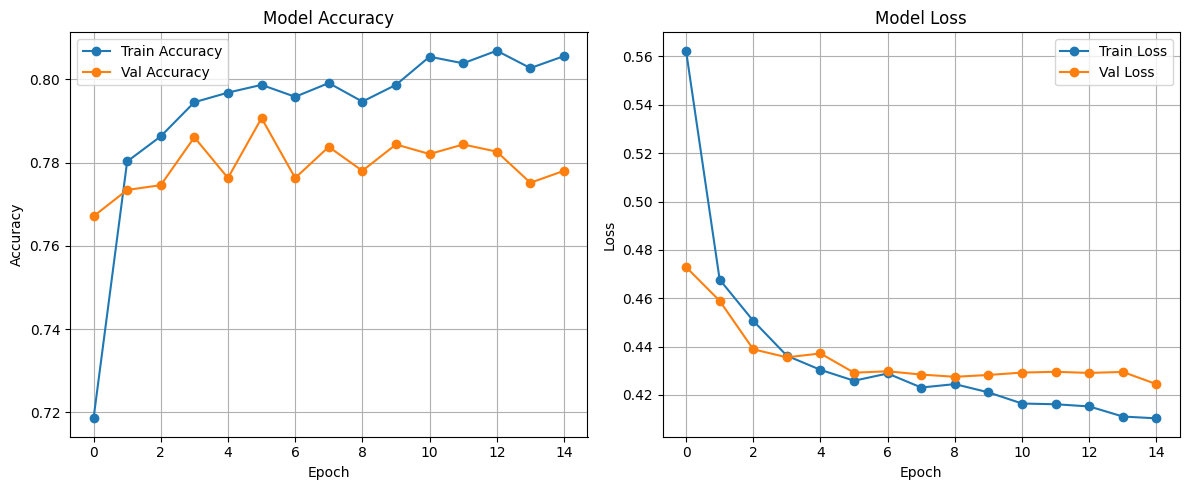

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
accuracies['ANN'] = max(history.history['val_accuracy'])

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_val_preds = rf.predict(X_val)
rf_acc = accuracy_score(y_val, rf_val_preds)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

accuracies['Random Forest'] = accuracy_score(y_val, rf_val_preds)

Random Forest Accuracy: 0.7936


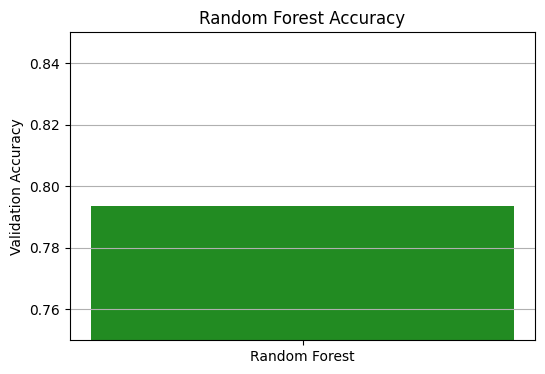

In [29]:
plt.figure(figsize=(6, 4))
plt.bar(['Random Forest'], [rf_acc], color='forestgreen')
plt.ylim(0.75, 0.85)
plt.ylabel('Validation Accuracy')
plt.title('Random Forest Accuracy')
plt.grid(axis='y')
plt.show()

# Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
et_val_preds = et.predict(X_val)
et_acc = accuracy_score(y_val, et_val_preds)
print(f"Extra Trees Accuracy: {et_acc:.4f}")
accuracies['Extra Trees'] = accuracy_score(y_val, et_val_preds)

Extra Trees Accuracy: 0.7901


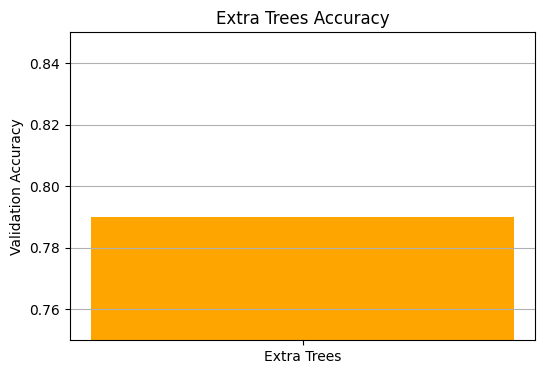

In [31]:
plt.figure(figsize=(6, 4))
plt.bar(['Extra Trees'], [et_acc], color='orange')
plt.ylim(0.75, 0.85)
plt.ylabel('Validation Accuracy')
plt.title('Extra Trees Accuracy')
plt.grid(axis='y')
plt.show()


# XGBoost 

In [32]:
X_train['PassengerGroup'] = pd.to_numeric(X_train['PassengerGroup'], errors='coerce')
X_val['PassengerGroup'] = pd.to_numeric(X_val['PassengerGroup'], errors='coerce')

X_train['PassengerNumber'] = pd.to_numeric(X_train['PassengerNumber'], errors='coerce')
X_val['PassengerNumber'] = pd.to_numeric(X_val['PassengerNumber'], errors='coerce')

In [33]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val_preds = xgb_model.predict(X_val)
xgb_acc = accuracy_score(y_val, xgb_val_preds)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

accuracies['XGBoost'] = accuracy_score(y_val, xgb_val_preds)

XGBoost Accuracy: 0.7947


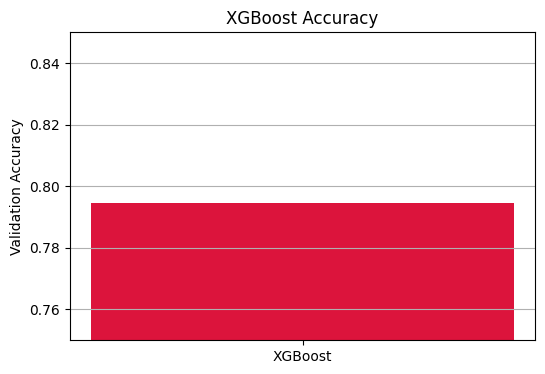

In [34]:
plt.figure(figsize=(6, 4))
plt.bar(['XGBoost'], [xgb_acc], color='crimson')
plt.ylim(0.75, 0.85)
plt.ylabel('Validation Accuracy')
plt.title('XGBoost Accuracy')
plt.grid(axis='y')
plt.show()


# LightGBM

In [35]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_val_preds = lgb_model.predict(X_val)
lgb_acc = accuracy_score(y_val, lgb_val_preds)
print(f"LightGBM Accuracy: {lgb_acc:.4f}")

accuracies['LightGBM'] = accuracy_score(y_val, lgb_val_preds)

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
LightGBM Accuracy: 0.8085


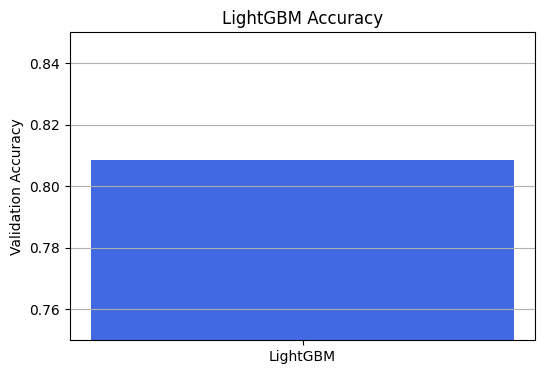

In [36]:
plt.figure(figsize=(6, 4))
plt.bar(['LightGBM'], [lgb_acc], color='royalblue')
plt.ylim(0.75, 0.85)
plt.ylabel('Validation Accuracy')
plt.title('LightGBM Accuracy')
plt.grid(axis='y')
plt.show()


In [37]:
for model_name, acc in accuracies.items():
    print(f"{model_name}: {acc:.4f}")

ANN: 0.7907
Random Forest: 0.7936
Extra Trees: 0.7901
XGBoost: 0.7947
LightGBM: 0.8085


In [38]:
best_model = max(accuracies, key=accuracies.get)
print(f"\n{best_model} with {accuracies[best_model]:.4f} accuracy")


LightGBM with 0.8085 accuracy


In [39]:
test_df['PassengerGroup'] = pd.to_numeric(test_df['PassengerGroup'], errors='coerce')
test_df['PassengerNumber'] = pd.to_numeric(test_df['PassengerNumber'], errors='coerce')

In [40]:
model_objects = {
    'Random Forest': rf,
    'Extra Trees': et,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

if best_model == 'ANN':
    test_preds = model.predict(test_df).flatten()
    test_preds = (test_preds > 0.5).astype(bool)
else:
    test_preds = model_objects[best_model].predict(test_df).astype(bool)

In [41]:
submission = pd.DataFrame({
    'PassengerId': PassengerId,
    'Transported': test_preds
})

submission.to_csv('submission.csv', index=False)